<a href="https://colab.research.google.com/github/Raaghashree/Intel-Products-Sentiment-Analysis/blob/main/ML_Sentiment_Analyser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CUSTOM MODEL(Not to be run)

In [ ]:
!pip install torch
!pip install accelerate -U
!pip install transformers[torch] -U
!pip install datasets transformers huggingface_hub
!apt-get install git-lfs

In [ ]:
import torch
torch.cuda.is_available()

In [ ]:
from datasets import load_dataset
imdb = load_dataset("imdb")
small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(3000))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(300))])

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)


In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

In [ ]:
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}


In [ ]:
from huggingface_hub import notebook_login
notebook_login()


In [ ]:
from transformers import TrainingArguments, Trainer

repo_name = "finetuning-sentiment-model-3000-samples"

training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=True,
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)


In [ ]:
trainer.train()


Step,Training Loss


TrainOutput(global_step=376, training_loss=0.30110574275889296, metrics={'train_runtime': 302.1825, 'train_samples_per_second': 19.856, 'train_steps_per_second': 1.244, 'total_flos': 782725021021056.0, 'train_loss': 0.30110574275889296, 'epoch': 2.0})

In [ ]:
trainer.evaluate()


<ipython-input-15-b1430cee0b64>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for f1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/f1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


{'eval_loss': 0.3272470235824585,
 'eval_accuracy': 0.8633333333333333,
 'eval_f1': 0.8637873754152824,
 'eval_runtime': 42.4653,
 'eval_samples_per_second': 7.065,
 'eval_steps_per_second': 0.447,
 'epoch': 2.0}

In [ ]:
trainer.push_to_hub()


**IMPLEMENTING MODEL**:

Installing necessary packages(Run from here)

In [ ]:
pip install langdetect googletrans==4.0.0-rc1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 9.1 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17395 sha256=d72a9be936e4fc512e33b27ff41b6df5ec8ac5b5bfc8c34d4af441d22c505266
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
  Cre

MODEL:

In [ ]:
from transformers import pipeline
sentiment_model = pipeline(model="Raagha/finetuning-sentiment-model-3000-samples")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Testing model on different languages

In [ ]:
sentiment_model(["Me encanta esta canción, es realmente buena!", "esta película apesta"])

#LABEL_0 represents negative sentiment
#LABEL_1 represents positive sentiment

[{'label': 'LABEL_1', 'score': 0.72124183177948},
 {'label': 'LABEL_0', 'score': 0.5078819394111633}]

**Importing the required packages**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from langdetect import detect
from googletrans import Translator

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Upload the files to be analysed**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Intel 14th gen data.csv to Intel 14th gen data.csv


**Choose file to perform analysis on**

In [ ]:
#Replace with different file name if required
df = pd.read_csv("Intel 14th gen data.csv")

**Preprocessing the data**

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
stop_words.update(['cpu','good','would','one','stop','processor','intel','chip','gen','run','pc','used','return','arrived','box','new','amazon','issue','day',"don't",'open','great','open','core','use','get','buy','work','even','without','well','product','got','im','fine','like','didnt','tried','despite','month','case','high'])


In [ ]:
print("Size of data:")
print("Before preprocessing:",df.shape)

def preprocessing(df):

    df.drop_duplicates(subset='reviewId', keep='first', inplace=True)
    df['reviewDescription'].fillna('', inplace=True)
    df['reviewDescription'] = df['reviewDescription'].astype(str).str.lower()

    def clean_text(text):
        text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
        words = nltk.word_tokenize(text)
        words = [word for word in words if word.isalpha()]  # Remove non-alphabetic tokens
        words = [word for word in words if word not in stop_words]  # Remove stop words
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        return ' '.join(lemmatized_words)

    df['reviewDescription'] = df['reviewDescription'].apply(clean_text)
    return df

df = preprocessing(df)
print("After preprocessing:",df.shape)

Size of data:
Before preprocessing: (349, 10)
After preprocessing: (349, 10)


Analysing sentiment of reviews

In [ ]:
tqdm.pandas()

def sentiment(review):
    try:
        result = sentiment_model(review[:512])[0]
        return result['label'], result['score']
    except Exception as e:
        print(f"Error processing review: {review[:50]}... | Error: {e}")
        return None, None

df[['sentiment_label', 'score']] = df['reviewDescription'].progress_apply(lambda x: pd.Series(sentiment(x)))

df = df.dropna(subset=['sentiment_label', 'score'])

df['sentiment'] = df['sentiment_label'].apply(lambda x: 'positive' if x == 'LABEL_1' else 'negative')


  0%|          | 0/349 [00:00<?, ?it/s]

Optional:

In [ ]:
#Run this statement to ensure proper sentiment analysis if any issues in metrics
'''
def sentiment_check(score, og_sent):
    if score > 0.8:
        return 'positive'
    return og_sent

df['sentiment'] = df.apply(lambda row: sentiment_check(row['score'], row['sentiment']), axis=1)
'''

In [ ]:
'''
reviews with ratingScore 5
Results in many false positives and affects recall
Can be done if resulting dataframe has false negatives
'''
#df['sentiment'] = df.apply(lambda row: 'positive' if row['ratingScore'] == 5 else row['sentiment'], axis=1)

Sentiments Tally:

In [ ]:
def comments(df):
    positive_comments = df[(df['sentiment'] == 'positive')]['reviewDescription'].tolist()
    negative_comments = df[(df['sentiment'] == 'negative')]['reviewDescription'].tolist()
    return positive_comments, negative_comments

positive_comments, negative_comments = comments(df)

# Print the count of positive and negative comments
print(f"Number of positive comments: {len(positive_comments)}")
print(f"Number of negative comments: {len(negative_comments)}")


Number of positive comments: 249
Number of negative comments: 100


Updated dataframe

In [ ]:
df.head()

,Id,reviewId,country,ratingScore,productAsin,reviewTitle,reviewDescription,sentiment_label,score,sentiment
0,1,R35XAKHE60A83L,United States,5,B0CQ1M1YXM,Snappy CPU Such Value for-<$250.00,uhd graphic low profile low heat tdp paired ar...,LABEL_1,0.501232,positive
1,2,R3ATB0W5WSXIEZ,India,5,B0CGJDKLB8,i9 14th gen is the beast!,upgraded super happy performance able achieve ...,LABEL_1,0.590715,positive
2,3,R3CC79PFLSC7R3,India,5,B0CGJDKLB8,Beast gaming 💪🐻,beast gaming world powerful set processer rtx ...,LABEL_1,0.561920,positive
3,4,R2XLUOMZDZXEH2,Mexico,5,B0CGJDKLB8,Excelente procesador y envío rápido,todo vino en orden perfectamente empacado comp...,LABEL_1,0.601160,positive
4,5,R15Z5SQ4FHA4VL,Mexico,5,B0CGJDKLB8,Una maravilla de procesador,el tope de gama en su momento igual que el ven...,LABEL_1,0.546774,positive


Overall sentiment of reviews

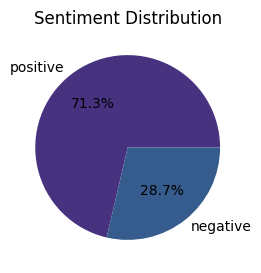

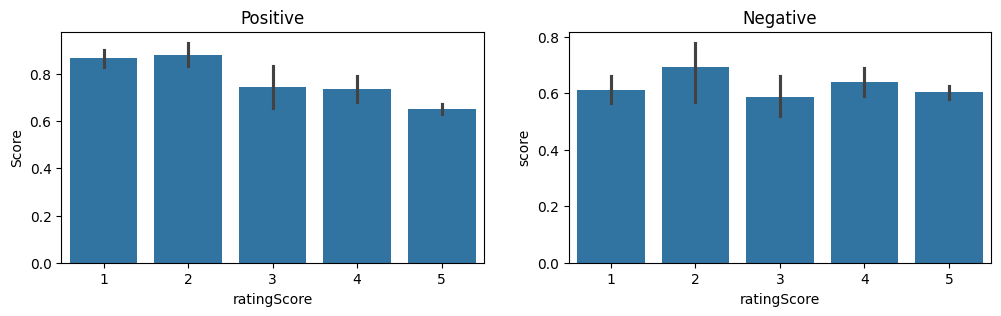

In [ ]:
positive_count = len(positive_comments)
negative_count = len(negative_comments)

sentiment_distribution = pd.Series([positive_count, negative_count], index=['positive', 'negative'])
plt.figure(figsize=(4, 3))
plt.pie(sentiment_distribution.values, labels=sentiment_distribution.index, autopct='%1.1f%%', colors=sns.color_palette('viridis'))
plt.title('Sentiment Distribution')
plt.show()

print("\n\n")
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

positive_df = df[df['sentiment'] == 'positive']
sns.barplot(data=positive_df, x='ratingScore', y='score', ax=axs[0])
axs[0].set_title('Positive')
axs[0].set_ylabel('Score')

negative_df = df[df['sentiment'] == 'negative']
sns.barplot(data=negative_df, x='ratingScore', y='score', ax=axs[1])
axs[1].set_title('Negative')
plt.show()


Extracting features using TF-IDF

Translating comments:   0%|          | 0/249 [00:00<?, ?it/s]

Translating comments:   0%|          | 0/100 [00:00<?, ?it/s]

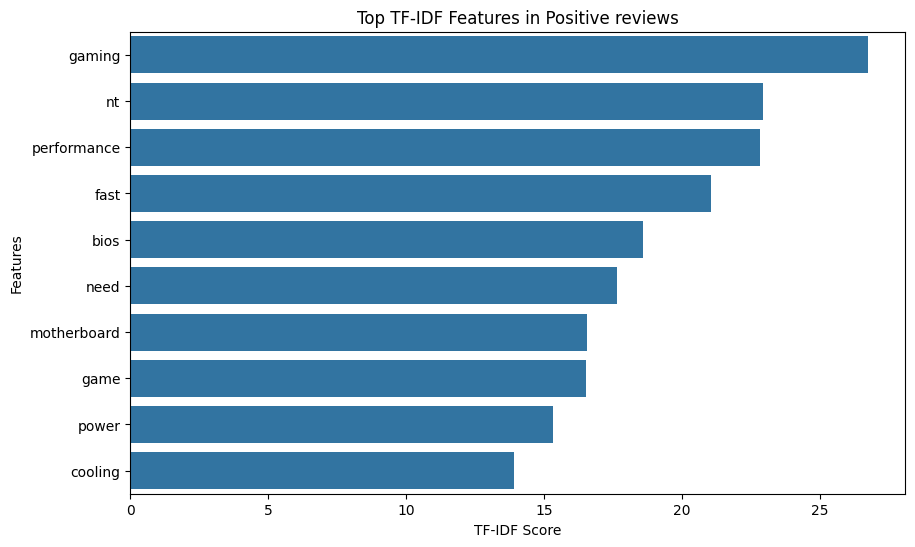

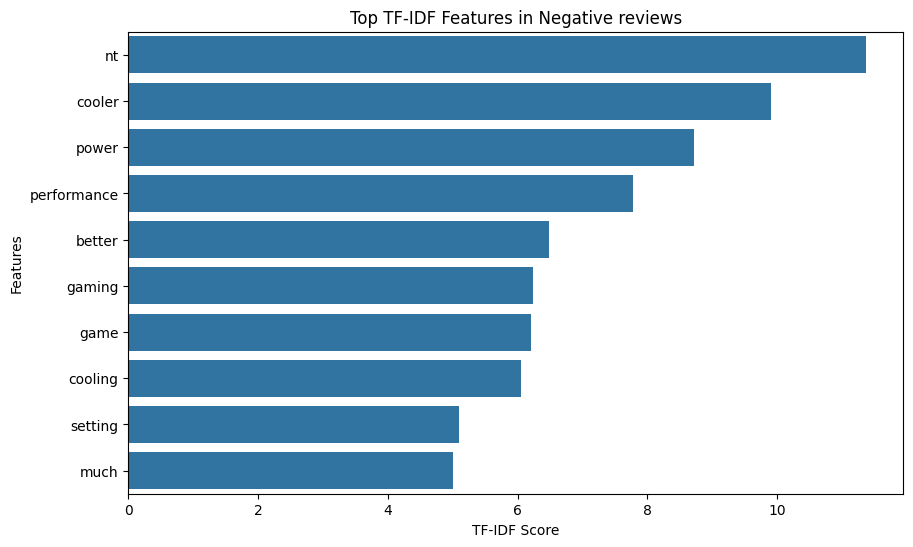

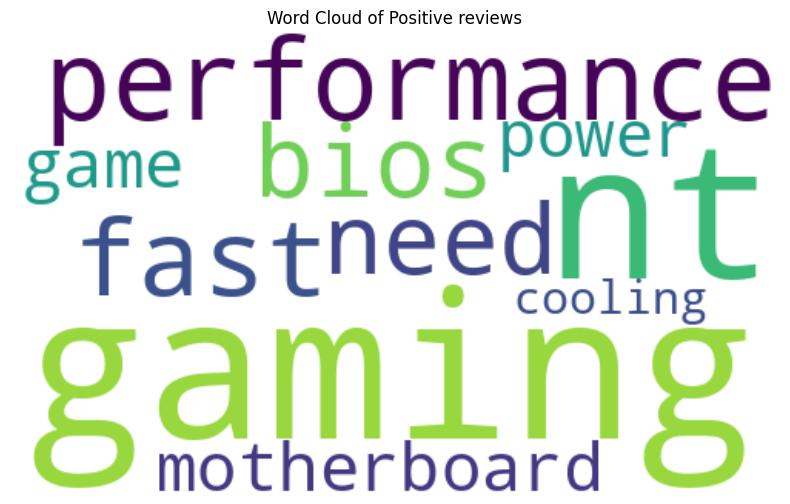

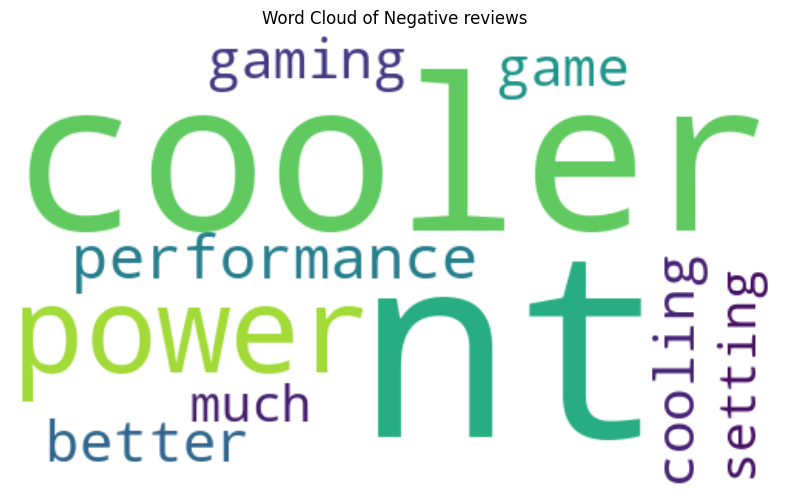

In [ ]:
tqdm.pandas()
translator = Translator()

def detect(review):
    try:
        lang = detect(review)
        if lang != 'en':
            translation = translator.translate(review, src=lang, dest='en')
            return translation.text
        else:
            return review
    except Exception:
        return None

def features(comments, n_features=10):
    stop_words_list = list(stop_words)
    vectorizer = TfidfVectorizer(max_features=n_features, stop_words=stop_words_list)

    translated_comments = []
    for comment in tqdm(comments, desc="Translating comments"):
        translated_comment = detect(comment)
        if translated_comment:
            translated_comments.append(translated_comment)

    tfidf_matrix = vectorizer.fit_transform(translated_comments)
    feature_names = vectorizer.get_feature_names_out()
    sums = tfidf_matrix.sum(axis=0)
    data = [(feature_names[col], sums[0, col]) for col in range(sums.shape[1])]
    ranking = pd.DataFrame(data, columns=['feature', 'tfidf']).sort_values(by='tfidf', ascending=False)

    return ranking

def plotting1(positive_features, negative_features):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='tfidf', y='feature', data=positive_features)
    plt.title('Top TF-IDF Features in Positive reviews')
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Features')
    plt.show()

    print("\n" * 3)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='tfidf', y='feature', data=negative_features)
    plt.title('Top TF-IDF Features in Negative reviews')
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Features')
    plt.show()

    print("\n" * 3)

    plt.figure(figsize=(10, 6))
    wordcloud_pos = WordCloud(width=500, height=300, background_color='white').generate_from_frequencies(dict(positive_features.values))
    plt.imshow(wordcloud_pos, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Positive reviews')
    plt.show()

    print("\n" * 3)

    plt.figure(figsize=(10, 6))
    wordcloud_neg = WordCloud(width=500, height=300, background_color='white').generate_from_frequencies(dict(negative_features.values))
    plt.imshow(wordcloud_neg, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Negative reviews')
    plt.show()

positive_features = features(positive_comments)
negative_features = features(negative_comments)

plotting1(positive_features, negative_features)


Training the model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

In [ ]:
import numpy as np
import pandas as pd
X = df['reviewDescription']
y = df['sentiment']

num_runs = 10
accuracies = np.zeros(num_runs)
precisions = np.zeros(num_runs)
recalls = np.zeros(num_runs)
f1_scores = np.zeros(num_runs)

for i in range(num_runs):
    # Splitting data into sections
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    vect = TfidfVectorizer()
    X_train_tfidf = vect.fit_transform(X_train)
    X_test_tfidf = vect.transform(X_test)

    model = LogisticRegression()
    model.fit(X_train_tfidf, y_train)

    y_pred = model.predict(X_test_tfidf)

    #Storing metrics
    accuracies[i] = accuracy_score(y_test, y_pred)
    precisions[i] = precision_score(y_test, y_pred, pos_label='positive')
    recalls[i] = recall_score(y_test, y_pred, pos_label='positive')
    f1_scores[i] = f1_score(y_test, y_pred, pos_label='positive')


Evaluating model performance

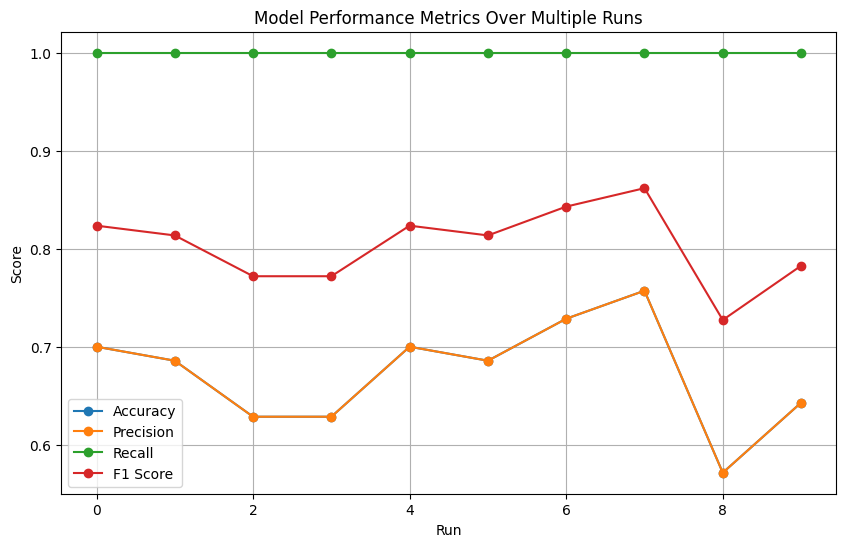


Average Accuracy: 0.6728571428571428
Average Precision: 0.6728571428571428
Average Recall: 1.0
Average F1 Score: 0.8032682364142666


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_runs), accuracies, label='Accuracy', marker='o')
plt.plot(range(num_runs), precisions, label='Precision', marker='o')
plt.plot(range(num_runs), recalls, label='Recall', marker='o')
plt.plot(range(num_runs), f1_scores, label='F1 Score', marker='o')

plt.xlabel('Run')
plt.ylabel('Score')
plt.title('Model Performance Metrics Over Multiple Runs')
plt.legend()
plt.grid(True)
plt.show()

# Print average metrics
print(f"\nAverage Accuracy: {np.mean(accuracies)}")
print(f"Average Precision: {np.mean(precisions)}")

#Recall may be affected due to false positives
print(f"Average Recall: {np.mean(recalls)}")
print(f"Average F1 Score: {np.mean(f1_scores)}")

Confusion Matrix:


Confusion Matrix:



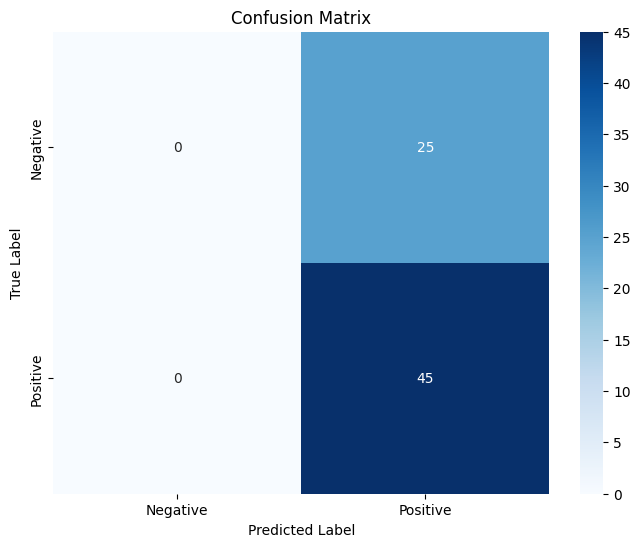


Results derived from Confusion Matrix

Accuracy: 0.6428571428571429
Precision: 0.6428571428571429
Recall: 1.0
F1 Score: 0.782608695652174



In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=['negative', 'positive'])

print("\nConfusion Matrix:\n")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

tn, fp, fn, tp = cm.ravel()

false_positives = fp

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("\nResults derived from Confusion Matrix")
print(f"\nAccuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}\n")
